In [1]:
import matplotlib.pyplot as plt
import pyart
import netCDF4
from glob import glob
import os
import numpy as np
import cartopy.crs as ccrs
import warnings 
import time 
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import rasterio
import matplotlib

warnings.filterwarnings("ignore", category=DeprecationWarning) 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
dpath = '/gws/nopw/j04/ncas_radar_vol2/pestdar/india/raw_data/JPR05'

fname = 'JPR200523092253.RAW2BXE'

fpath = os.path.join(dpath, fname)

inc_var = ['differential_reflectivity',
             'reflectivity',
             'spectrum_width',
             'velocity']
radar=pyart.io.read_sigmet(fpath, include_fields = inc_var)

fields = sorted(list(radar.fields))
    
interval = np.hstack([np.linspace(0, 0.45), np.linspace(0.55, 1)])
cols = plt.cm.seismic(interval)
cmap_vel = matplotlib.colors.LinearSegmentedColormap.from_list('name', cols)

plt_names = ['Differential Reflectivity', 'Reflectivity', 'Spectrum Width', 'Doppler Velocity']

plt_cols = ['pyart_RefDiff', 'pyart_HomeyerRainbow','pyart_NWSRef', cmap_vel]
vmin = [-2, -30,0,-15]
vmax = [10, 60,5,15]
units = ['dB','dBZ','m/s','m/s']

plt_order = [2,1,3,4]




In [53]:
fnames =  os.listdir(dpath)
os.path.join(dpath, fnames[0])

'/gws/nopw/j04/ncas_radar_vol2/pestdar/india/raw_data/JPR04/JPR200401000253.RAWM1MX'

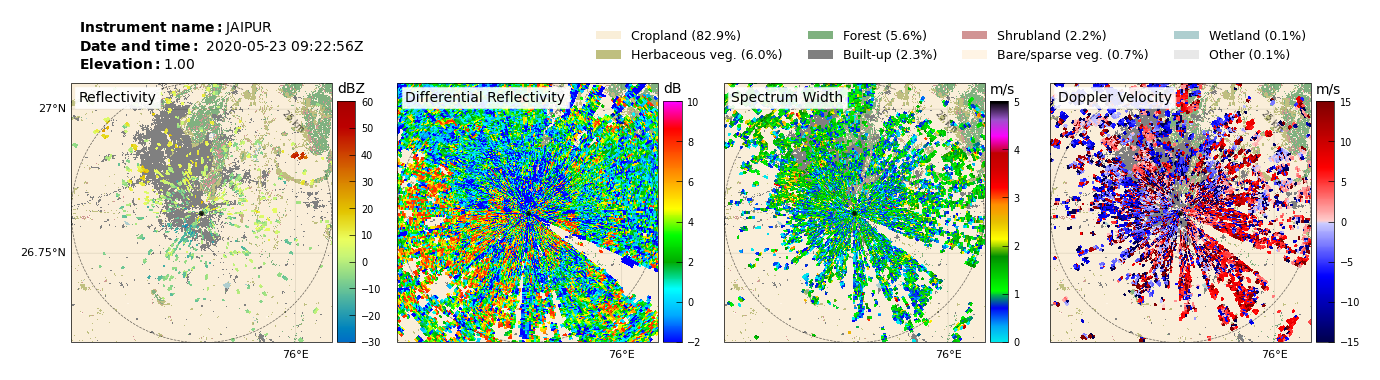

Run time: 5.846920967102051seconds


In [7]:
startTime = time.time()

## set up plotting
display = pyart.graph.RadarMapDisplay(radar)

## Plotting Options
ele = 1 #Elevation
#R = 50#  #Min and Mac Range from Radar in km

# set the figure title and show
instrument_name = radar.metadata['instrument_name'].decode('utf-8')
time_start = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
time_text = ' ' + time_start.strftime('%Y-%m-%d %H:%M:%SZ')
elevation = radar.fixed_angle['data'][ele]
title = instrument_name + time_text + ' Elevation %.2f' % (elevation)


## Figure Options
width=8 #in inches
height=2 #in inches

fig = plt.figure(figsize=(width, height), dpi = 200)
nplts = len(fields)
nrows=1
ncols= int(nplts/nrows)

## Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])
## adjust plot area 
x=0.4
r = 25

min_lat  = radar.latitude['data'][0]  - (r / 6378 ) * (180 / np.pi)
max_lat  = radar.latitude['data'][0]  + (r / 6378 ) * (180 / np.pi)

min_lon = radar.longitude['data'][0] - (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)
max_lon = radar.longitude['data'][0] + (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)

#min_lon = radar.longitude['data'][0]-2*x
#max_lon = radar.longitude['data'][0]+2*x

#min_lat = radar.latitude['data'][0]-2*x
#max_lat = radar.latitude['data'][0]+2*x


## get land cover info
rst, img_ext, cmap, norm, name, lcp = get_land_cover(radar, projection)


for field in fields:
    pnum = fields.index(field)
    ##create new axes for each field
    ax = plt.subplot(nrows,ncols,plt_order[pnum],projection=projection)
    plt.setp(ax.spines.values(), linewidth=0.25)

    ##format gridlines and labels
    xspace = 0.5
    yspace = 0.25
    lon_lines=np.arange(np.floor(min_lon), np.ceil(max_lon)+xspace, xspace)
    lat_lines=np.arange(np.floor(min_lat), np.ceil(max_lat)+yspace, yspace)
    gl = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, alpha = 0.7, zorder = 0.5, linewidth = 0.25)
    gl.xlocator = mticker.FixedLocator(lon_lines)
    gl.ylocator = mticker.FixedLocator(lat_lines)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': '4'}
    gl.ylabel_style = {'size': '4'}
    gl.xpadding = 8
    adjust_labels(gl)
        
    
    ## plot each field
    display.plot_ppi_map(field,ele,ax=ax, vmin=vmin[pnum], vmax=vmax[pnum], title_flag= False, 
                         colorbar_flag = False, cmap = plt_cols[pnum], embelish = False, alpha = 1.0,
                         min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                         projection=projection,fig=fig, lat_0=radar.latitude['data'][0], lon_0=radar.longitude['data'][0])
    
    
    ## plot landcover raster
    ax.imshow(rst, extent = img_ext, cmap = cmap, norm =norm, interpolation='nearest', alpha = 0.5, zorder = 0.5)
    
    ## add title
    ax.text(0.03,0.97, plt_names[pnum], fontsize = 5, bbox=dict(facecolor=(1,1,1,0.9),
                                        edgecolor=(1,1,1,0.5),linewidth = 0.5, pad = 1.25), transform=ax.transAxes, va = 'top', ha = 'left', zorder = 10)
    

    ## format colorbar
    divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="7%", pad=0.075, axes_class = plt.Axes)
    
    if units[pnum]:
        height = '93%'
    else:
        height = '100%'
    
    cax =inset_axes(ax, width="7%",  # width = 5% of parent_bbox width
                   height=height,  # height : 50% 
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
    
    cbar = plt.colorbar(ax.collections[0], cax=cax, orientation="vertical")
    cbar.ax.tick_params(axis='y', direction='in', labelsize = 3.5, pad = 2, width = 0.25, length = 2)
    cbar.outline.set_linewidth(0.25)
    #cax.set_ylabel(radar.fields[field]['units'], rotation = 270, fontsize = 12,  weight="bold", labelpad = 4)
    ax.set_title(units[pnum], y = 0.94, x = 1.02, 
                  fontsize = 5, va = 'top', ha = 'left')
    
    ## add range rings
    range_rings = [25,50,75,100,125,150]
    label_range_ring(range_rings, ax, 45)
    
    ## add point for radar
    ax.plot(radar.longitude['data'][0], radar.latitude['data'][0], marker = 'o', markersize = 1, c = 'black', alpha = 0.7, transform = ccrs.PlateCarree())

#title = instrument_name + time_text + ' Elevation %.2f' % (elevation)

title = '$\\bf{Instrument\ name:}$' + '{}'.format(instrument_name) + '\n' + '$\\bf{Date\ and\ time:}$' + '{}'.format(time_text) + '\n' + '$\\bf{Elevation:}$' + '{:.2f}'.format(elevation)
#title = 'Location: ' + '{}'.format(instrument_name) + '\n' + 'Data and Time: ' + '{}'.format(time_text) + '\n' + 'Elevation: ' + '{}'.format(ele)
plt.suptitle(title, fontsize=5, y = 0.92, x = 0.13, ha = 'left', va = 'center')
plt.subplots_adjust(hspace=0.001,wspace=0.25)   

#land cover legend
sort_inds = np.flip(np.argsort(lcp))
patches = [mpatches.Patch(color=cmap(i), label='{} ({:.1f}%)'.format(name[i], lcp[i]), linewidth=0, alpha = 0.5) for i in sort_inds]
fig.legend(handles=patches, fontsize = 4.5, loc='center right', bbox_to_anchor=(0.9, 0.92), borderaxespad=0., ncol=4, frameon=False)
    
sname = 'salalah_' + time_start.strftime('%Y-%m-%d') + '_' + time_start.strftime('%H%M%SZ')+'.png'
spath = os.path.join('/gws/nopw/j04/ncas_radar_vol1/eeslb/oman_test_plots', '20200401', sname)

#plt.savefig(spath, format='png',bbox_inches='tight')
plt.show()

executionTime = (time.time() - startTime)
print('Run time: ' + str(executionTime) + 'seconds')

In [58]:
title = '$\\bf{Instrument\ name:}$' + '{}'.format(instrument_name)

$\bf{Instrument\ name:}$DELHI


In [4]:
from osgeo import gdal
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
from osgeo import osr
import cartopy.crs as ccrs
import rasterio
import warnings 
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import pyart
import os 

def get_land_cover(radar, projection):
    
    lcpath = '/gws/nopw/j04/ncas_radar_vol1/eeslb/pestdar/data/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'
    
    r = 100

    min_lat  = radar.latitude['data'][0]  - (r / 6378 ) * (180 / np.pi)
    max_lat  = radar.latitude['data'][0]  + (r / 6378 ) * (180 / np.pi)
    min_lon = radar.longitude['data'][0] - (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)
    max_lon = radar.longitude['data'][0] + (r / 6378 ) * (180 / np.pi) / np.cos(radar.latitude['data'][0] * np.pi/180)

    #get data from window based on map extent 
    
    with rasterio.open(lcpath) as src:
        src_cmap = src.colormap(1)
        rst = src.read(1, window=from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform))
        gt = src.window_transform(from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform))

    #reclassify forest subtypes
    mask = np.where(np.logical_and(rst>=111, rst<=126))
    rst[mask] = 10

    unique_vals = np.unique(rst)
    
    #group low % types
    for i in unique_vals:
        total_count = np.size(rst)
        val_count = np.size(rst[rst == i])
        per = (val_count/total_count)*100
        if per < 0.1:
            rst[rst == i] = 0

    unique_vals = np.unique(rst)

    class_names = ['Other', 'Forest', 'Shrubland', 'Herbaceous veg.', 'Cropland', 'Built-up', 'Bare/sparse veg.', 'Snow & ice', 
                   'Water', 'Wetland', 'Moss/lichen', 'Open sea']

    class_values = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '200']
    col = ['lightgray', 'darkgreen', 'brown', 'olive', 'wheat', 'black', 'blanchedalmond', 'white', 'lightblue', 'cadetblue', 'white', 'lightblue']


    #get names and colors
    name = []
    c = []
    lcp = []
    for i in range(len(unique_vals)):
        data_ind = unique_vals[i]
        ind = class_values.index(str(data_ind))
        name.append(class_names[ind])
        c.append(col[ind])
        new_val = len(c)-1
        rst[rst == data_ind] = new_val
        lcp.append((np.size(rst[rst == new_val])/np.size(rst))*100)
        #print('Name: ', class_names[ind], ' Colour: ', col[ind], new_val)

    #create colormap and set bounds 
    cmap = matplotlib.colors.ListedColormap(c)
    bounds = np.unique(rst)
    norm = colors.BoundaryNorm(np.arange(len(bounds)+1)-0.5,cmap.N)

    ## reproject bounds to lambert conformal and set raster extent
    lower_left = projection.transform_point(min_lon, min_lat, ccrs.PlateCarree())
    upper_right = projection.transform_point(max_lon, max_lat, ccrs.PlateCarree())

    img_ext = (lower_left[0], upper_right[0], lower_left[1], upper_right[0])

    ## plot
   # plot = ax.imshow(rst, extent = img_ext, cmap = cmap, norm = norm, interpolation='nearest', alpha = 0.7)
   # ax.gridlines(ccrs.PlateCarree(), draw_labels = True)

    ## add legend 
    #patches = [mpatches.Patch(color=cmap(i), label=name[i], alpha = 0.7) for i in range(len(name))]
    # put those patched as legend-handles into the legend
    #plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    return rst, img_ext, cmap, norm, name, lcp

In [5]:
def label_range_ring(range_rings_in_km, ax, loc):
    loc_r = np.radians(loc)
    transform = ccrs.AzimuthalEquidistant(central_longitude=radar.longitude['data'][0], central_latitude=radar.latitude['data'][0])
    
    for ring in range_rings_in_km:
        angle = np.linspace(0., 2.0 * np.pi, 360)
        mask_angle = 22/ring #calculate angle needed for same length 'cut out' on each range ring
        
        for i in range(len(angle)):
            if loc_r-(mask_angle/2) <= angle[i] <= loc_r+(mask_angle/2):
                angle[i] =np.nan #nan values to exlude from plot where label will go
        

        label = (str(ring) + ' km')
        xpts = ring * 1000. * np.sin(angle)
        ypts = ring * 1000. * np.cos(angle)
        rot = 360 - loc
        ax.plot(xpts, ypts, linestyle='--', c = 'black', linewidth = 0.25, transform = transform, zorder = 9, alpha = 0.6)
        txt = ax.text(ring*1000*np.sin(loc_r),ring*1000*np.cos(loc_r),label, va = 'center', ha = 'center', fontsize = 3, alpha = 0.7,
                color = 'black', clip_on = True, transform = transform, rotation = rot)
        txt.clipbox = ax.bbox

def adjust_labels(gridlines):
    ## some rubbish to turn the correct labels on/off
    if plt_order[pnum]==1:
        gl.right_labels = False
        #gl.bottom_labels = False
        gl.top_labels = False
        
    if plt_order[pnum]== 2 or plt_order[pnum]== 3:
        gl.left_labels = False
        gl.right_labels = False
        #gl.bottom_labels = False
        gl.top_labels = False

    if plt_order[pnum]== 6 or plt_order[pnum]== 7:
        gl.left_labels = False
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = False
        
    if plt_order[pnum]== 4:
        gl.left_labels = False
        gl.right_labels = False
        #gl.bottom_labels = False
        gl.top_labels = False
    
    if plt_order[pnum]== 5:
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = False
            
    if plt_order[pnum]== 8:
        gl.left_labels = False
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = False